In [1]:
#imports
import pandas as pd
import numpy as np
import os 
import xml.etree.ElementTree as ET
from lxml import objectify

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from keras import layers
from keras import models
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from glob import glob

import cv2
import matplotlib.pylab as plt

In [2]:
# Reading in Images
defect_img_dir = glob('images/images/*/*.jpg')
len(defect_img_dir)

2306

In [3]:
# Reading in Labels

defect_label_dir = glob('label/label/*.xml')
len(defect_label_dir)

2280

In [4]:
#unique labels
output = []
for x in defect_label_dir:
    if x not in output:
        output.append(x)


print(len(output))

2280


In [5]:
#Defect tags
defect_tag = {}
for i in defect_img_dir:
    defect = os.path.split(os.path.split(i)[0])[1] #taking defect 
    key = os.path.basename(i)
    defect_tag[key] = defect
print(len(defect_tag)) #correct

2294


In [6]:
#name of image
name_img = [] #with .jpg
file_id = [] #without .jpg
dir_dict = {}
for i in defect_img_dir:
    a = os.path.basename(i)
    name_img.append(a)
    dir_dict[a] = i
name_img
#len(name_img)

for i in name_img:
    result = i.removesuffix('.jpg')
    file_id.append(result)
len(file_id)

2306

In [7]:
len(dir_dict) #correct

2294

In [8]:
#numbers of unique images of defects 
output = []
for x in name_img:
    if x not in output:
        output.append(x)
print(len(output))

2294


In [9]:
#which image has which defect; probably not needed
tag_name = []
for i in defect_img_dir:
    tag_name.append(os.path.basename(os.path.dirname(i)))
len(tag_name)

2306

In [10]:
#height and width of picture; probably not needed
height = []
width = []

for i in defect_img_dir:
    picture_size = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    height.append(picture_size.shape[0])
    width.append(picture_size.shape[1])



In [11]:
len(height)
len(width)

2306

In [12]:
# dictionary; defect ID
dict_defect_ID = {
  "crease": 0,
  "crescent_gap": 1,
  "inclusion": 2,
  "oil_spot": 3,
  "punching_hole": 4,
  "rolled_pit": 5,
  "silk_spot": 6,
  "waist folding": 7,
  "water_spot": 8,
  "welding_line": 9,
}

In [13]:
# xml file and important infos about images
def read_xml(path):
    
    tree = ET.parse(path)
    root = tree.getroot()
    
    dict = {}
    
    filename = root[1].text
    dict['filename'] = filename
    dict['directory'] = dir_dict[filename]
    dict['xmin'] = int(root[6][4][0].text) #xmin
    dict['ymin'] = int(root[6][4][1].text) #ymin
    dict['xmax'] = int(root[6][4][2].text) #xmax
    dict['ymax'] = int(root[6][4][3].text) #yman
    dict['width'] = int(root[4][0].text)
    dict['height'] = int(root[4][1].text)
    dict['defect'] = defect_tag[filename]
    dict['defect_ID'] = dict_defect_ID[dict['defect']]
    dict['img_array'] = np.array(cv2.imread(dict['directory'], cv2.IMREAD_GRAYSCALE))
    
   

    
    return dict

read_xml(defect_label_dir[8]) #correct

{'filename': 'img_01_424799300_01133.jpg',
 'directory': 'images/images\\crescent_gap\\img_01_424799300_01133.jpg',
 'xmin': 1696,
 'ymin': 484,
 'xmax': 1911,
 'ymax': 1000,
 'width': 2048,
 'height': 1000,
 'defect': 'crescent_gap',
 'defect_ID': 1,
 'img_array': array([[ 6,  6,  5, ..., 79, 76, 74],
        [ 6,  6,  6, ..., 77, 75, 75],
        [ 7,  6,  6, ..., 76, 75, 77],
        ...,
        [18, 18, 17, ..., 71, 65, 66],
        [16, 17, 16, ..., 69, 65, 67],
        [14, 16, 15, ..., 67, 62, 64]], dtype=uint8)}

In [14]:
#list of infos about images

d1 = []
for i in defect_label_dir:
    
    d1.append(read_xml(i))

d1

[{'filename': 'img_01_3402617700_00001.jpg',
  'directory': 'images/images\\crescent_gap\\img_01_3402617700_00001.jpg',
  'xmin': 1738,
  'ymin': 806,
  'xmax': 1948,
  'ymax': 993,
  'width': 2048,
  'height': 1000,
  'defect': 'crescent_gap',
  'defect_ID': 1,
  'img_array': array([[  7,   8,   5, ..., 136, 130, 132],
         [  8,   9,   6, ..., 132, 132, 134],
         [  7,   9,   7, ..., 133, 136, 139],
         ...,
         [ 11,  10,  10, ..., 135, 134, 134],
         [ 10,  10,   9, ..., 135, 133, 134],
         [ 10,   9,   9, ..., 135, 132, 135]], dtype=uint8)},
 {'filename': 'img_01_3402617700_01009.jpg',
  'directory': 'images/images\\crescent_gap\\img_01_3402617700_01009.jpg',
  'xmin': 1756,
  'ymin': 298,
  'xmax': 1967,
  'ymax': 858,
  'width': 2048,
  'height': 1000,
  'defect': 'crescent_gap',
  'defect_ID': 1,
  'img_array': array([[  6,   6,   6, ...,  65,  65,  67],
         [  5,   5,   5, ...,  65,  67,  71],
         [  7,   7,   7, ...,  65,  68,  72],
    

In [15]:
#DataFrame 

mydf = pd.DataFrame(d1)
mydf

,filename,directory,xmin,ymin,xmax,ymax,width,height,defect,defect_ID,img_array
0,img_01_3402617700_00001.jpg,images/images\crescent_gap\img_01_3402617700_0...,1738,806,1948,993,2048,1000,crescent_gap,1,"[[7, 8, 5, 6, 7, 7, 9, 7, 6, 6, 6, 6, 6, 7, 7,..."
1,img_01_3402617700_01009.jpg,images/images\crescent_gap\img_01_3402617700_0...,1756,298,1967,858,2048,1000,crescent_gap,1,"[[6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 7, 7, 7, 6, 5,..."
2,img_01_3436789500_00004.jpg,images/images\crease\img_01_3436789500_00004.jpg,981,182,2046,249,2048,1000,crease,0,"[[16, 14, 12, 13, 14, 14, 14, 14, 13, 15, 13, ..."
3,img_01_3436814600_00259.jpg,images/images\silk_spot\img_01_3436814600_0025...,746,17,1011,993,2048,1000,silk_spot,6,"[[12, 11, 10, 10, 10, 11, 12, 12, 12, 12, 11, ..."
4,img_01_3436815300_00473.jpg,images/images\silk_spot\img_01_3436815300_0047...,814,17,1522,978,2048,1000,silk_spot,6,"[[15, 17, 14, 14, 13, 13, 16, 14, 14, 13, 13, ..."
...,...,...,...,...,...,...,...,...,...,...,...
2275,img_08_4406743300_00483.jpg,images/images\silk_spot\img_08_4406743300_0048...,690,260,840,675,2048,1000,silk_spot,6,"[[82, 76, 78, 79, 83, 78, 80, 79, 81, 80, 80, ..."
2276,img_08_4406743300_00486.jpg,images/images\silk_spot\img_08_4406743300_0048...,959,484,1017,889,2048,1000,silk_spot,6,"[[79, 76, 78, 82, 81, 79, 77, 76, 77, 78, 77, ..."
2277,img_08_4406743300_00698.jpg,images/images\silk_spot\img_08_4406743300_0069...,579,348,831,684,2048,1000,silk_spot,6,"[[80, 77, 78, 76, 77, 78, 75, 75, 80, 79, 78, ..."
2278,img_08_4406743300_00699.jpg,images/images\silk_spot\img_08_4406743300_0069...,571,571,853,843,2048,1000,silk_spot,6,"[[76, 75, 77, 77, 76, 77, 77, 75, 81, 76, 75, ..."


In [16]:
mydf['defect_ID'].value_counts()  #numbers of defects

6    649
8    287
9    267
1    224
4    215
2    211
3    204
7    144
0     51
5     28
Name: defect_ID, dtype: int64

<Axes: >

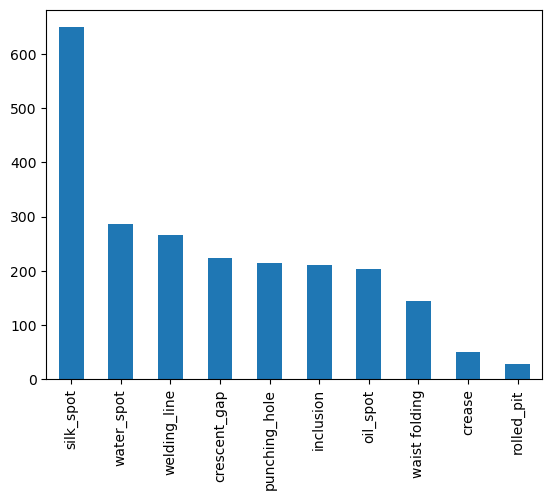

In [17]:
mydf['defect'].value_counts().plot(kind = 'bar')   #numbers of defects

<Axes: ylabel='defect'>

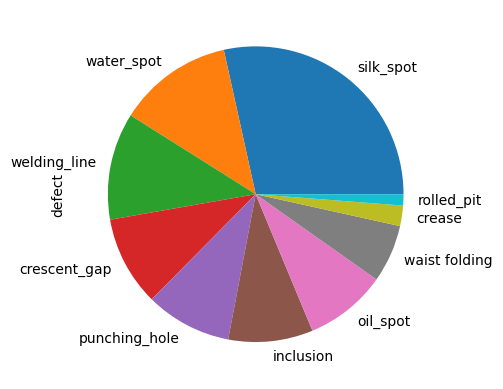

In [18]:
mydf['defect'].value_counts().plot(kind = 'pie')  #same as above but pie chart

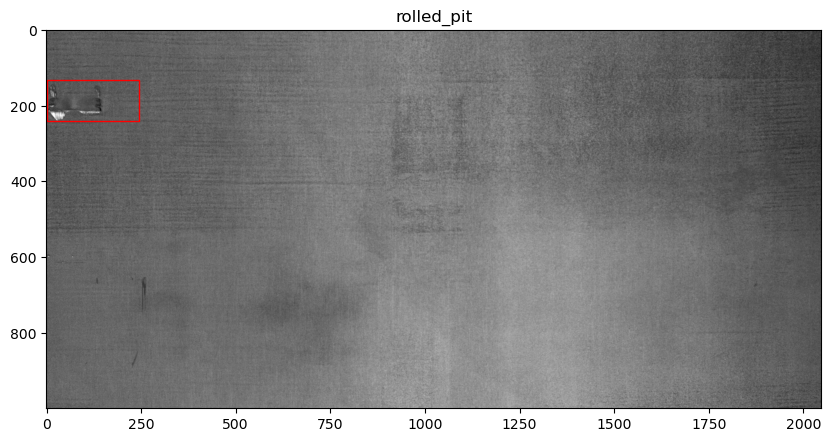

In [19]:
#function to show images with defect marked 
def show_defect(ID, rectangle = True, Title = True):
    filename, directory, xmin, ymin, xmax, ymax, width, height, defect = mydf.loc[ID, 
    ['filename', 'directory', 'xmin', 'ymin', 'xmax', 'ymax', 'width', 'height', 'defect']]   
    
    img_mpl = plt.imread(directory)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(img_mpl, cmap='gray')
    if rectangle:
        rectangle = plt.Rectangle((xmin,ymin), width = xmax - xmin, height = ymax - ymin, facecolor = 'none', edgecolor = 'red')
        ax.add_patch(rectangle)
    if Title:
        plt.title(defect)
    #ax.axis('off')
    plt.show
show_defect(799) #correct

In [20]:
X = mydf['img_array']
X = X.values.tolist()
X

[array([[  7,   8,   5, ..., 136, 130, 132],
        [  8,   9,   6, ..., 132, 132, 134],
        [  7,   9,   7, ..., 133, 136, 139],
        ...,
        [ 11,  10,  10, ..., 135, 134, 134],
        [ 10,  10,   9, ..., 135, 133, 134],
        [ 10,   9,   9, ..., 135, 132, 135]], dtype=uint8),
 array([[  6,   6,   6, ...,  65,  65,  67],
        [  5,   5,   5, ...,  65,  67,  71],
        [  7,   7,   7, ...,  65,  68,  72],
        ...,
        [  7,   7,   8, ..., 101,  96,  93],
        [  7,   7,   7, ..., 101, 100,  97],
        [  8,   7,   6, ...,  93,  96,  98]], dtype=uint8),
 array([[ 16,  14,  12, ..., 147, 145, 138],
        [ 15,  14,  13, ..., 147, 139, 146],
        [ 14,  13,  14, ..., 141, 138, 136],
        ...,
        [ 15,  15,  14, ..., 142, 136, 138],
        [ 15,  15,  15, ..., 141, 140, 142],
        [ 15,  15,  15, ..., 145, 147, 148]], dtype=uint8),
 array([[ 12,  11,  10, ..., 102, 100, 100],
        [ 12,  11,  11, ..., 104, 101, 101],
        [ 10,  1

In [21]:
y = mydf['defect_ID']
y = y.values.tolist()
y = np.array(y)
y

array([1, 1, 0, ..., 6, 6, 1])

In [22]:
""""
def get_dataset(df):
    im_ds = tf.data.Dataset.from_tensor_slices(mydf.directory)
        
    xmin = tf.data.Dataset.from_tensor_slices(mydf['xmin'].values)
    ymin = tf.data.Dataset.from_tensor_slices(mydf['ymin'].values)
    xmax = tf.data.Dataset.from_tensor_slices(mydf['xmax'].values)
    ymax = tf.data.Dataset.from_tensor_slices(mydf['ymax'].values)
    labels = tf.data.Dataset.from_tensor_slices(mydf['defect_ID'].values)

    labels_ds = tf.data.Dataset.zip((labels,xmin,xmax,ymin,ymax)) 
    dataset = tf.data.Dataset.zip((im_ds,labels_ds))
    return dataset
"""

'"\ndef get_dataset(df):\n    im_ds = tf.data.Dataset.from_tensor_slices(mydf.directory)\n        \n    xmin = tf.data.Dataset.from_tensor_slices(mydf[\'xmin\'].values)\n    ymin = tf.data.Dataset.from_tensor_slices(mydf[\'ymin\'].values)\n    xmax = tf.data.Dataset.from_tensor_slices(mydf[\'xmax\'].values)\n    ymax = tf.data.Dataset.from_tensor_slices(mydf[\'ymax\'].values)\n    labels = tf.data.Dataset.from_tensor_slices(mydf[\'defect_ID\'].values)\n\n    labels_ds = tf.data.Dataset.zip((labels,xmin,xmax,ymin,ymax)) \n    dataset = tf.data.Dataset.zip((im_ds,labels_ds))\n    return dataset\n'

In [23]:
#model z [10] bibliografii (wrzucanie tutaj jest pojedynczego obrazu dlatego input_shape = (2048,1000, 1 <----))
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1000,2048,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 998, 2046, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 499, 1023, 32)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 497, 1021, 64)     18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 248, 510, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 246, 508, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 7997952)           0

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X_train = np.array(X_train)
X_test = np.array([X_test])
y_train = np.array([y_train])
y_test = np.array([y_test])
X_test.shape

(1, 570, 1000, 2048)

In [27]:
#X_train = X_train.reshape((1710, 1000, 2048, 1))
X_train = X_train.astype('float32')/255

#X_test = X_test.reshape((570, 1000, 2048, 1))
X_test = X_test.astype('float32')/255

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)


In [30]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64)

ValueError: Data cardinality is ambiguous:
  x sizes: 1710
  y sizes: 1
Make sure all arrays contain the same number of samples.

In [ ]:
#sprawdzic jak z [10] ten dataset MNIST jest robiony, jakie są formaty liczbowe X_train, y_train - array czy listy itd; 
#zrobic tak samo